<h2>Dataloader</h2>

In [1]:
import os
import wandb
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import time
import matplotlib.pyplot as plt

In [2]:
# Define the paths
dataset_dir = '/kaggle/input/catdog'
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

In [3]:
class CatDogDataset(Dataset):
    def __init__(self, root_dir, output_size:tuple=(256,256), transforms=None):
        self.root_dir = root_dir
        self.output_size = output_size
        self.transforms = transforms
        self.data = []
        self.classes = os.listdir(root_dir)
        
        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            for file_name in os.listdir(class_path):
                self.data.append((os.path.join(class_path, file_name), class_name))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        image = Image.open(img_path)
        
        if self.transforms:
            # Apply augmentations for training
            image = self.transforms(image)
        
        transform = transforms.Compose([transforms.Resize(self.output_size), transforms.ToTensor()])
        image = transform(image)
        
        label = self.classes.index(class_name)
        return image, label

In [4]:
dataset = CatDogDataset(root_dir=train_dir)
test_dataset = CatDogDataset(root_dir=test_dir)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_subset, val_subset = random_split(dataset, [train_size, val_size])

TRANSFORMS = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomRotation(15)])
train_subset.dataset.transforms = TRANSFORMS

In [5]:
train_dataloader = DataLoader(train_subset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

torch.Size([256, 256, 3]) tensor(0)


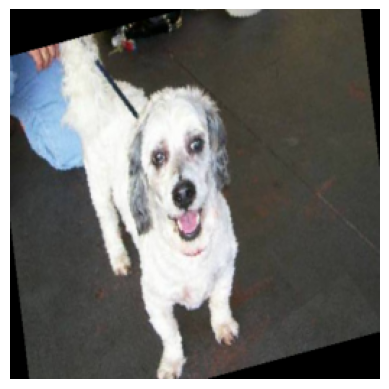

In [6]:
imgs, label = next(iter(train_dataloader))
img = imgs[0].permute((1, 2, 0))
print(img.size(), label[0])

plt.imshow(img)
plt.axis('off')  # Optional: Hide axes for better visualization
plt.show()


<h2>Model</h2>

In [7]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

In [8]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

<h2>Training</h2>

In [9]:
NUM_EPOCHS=5
BATCH_SIZE=32
LR=1e-4
STEP_SIZE=10
BETAS = (0.9, 0.999)
EPS=1e-08
GAMMA=0.67
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
DEVICE

device(type='cuda')

In [11]:
class Network:
    def __init__(self, for_inference=False, pretrained=False,
                train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,
                lr=LR, betas=BETAS, step_size=STEP_SIZE, device=DEVICE, 
                num_epochs=NUM_EPOCHS, eps=EPS, gamma=GAMMA):
        self.for_inference=for_inference
        self.model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=2).to(device)
        self.device = device
        self.pretrained = pretrained
        
        if not self.for_inference:
            self.loss_fn = nn.CrossEntropyLoss().to(device)
            self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=betas, eps=eps)
            self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=step_size, gamma=gamma)

            self.train_dataloader = train_dataloader
            self.valid_dataloader = valid_dataloader
            self.num_epochs = num_epochs
            
        if self.pretrained:
            # Load the pretrained weights
            pretrained_model = models.resnet18(pretrained=True)
            pretrained_dict = pretrained_model.state_dict()

            # Get the model's state dict
            model_dict = self.model.state_dict()

            # Filter out the weights for the final fully connected layer
            pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and 'fc' not in k}

            # Update the model's state dict with the pretrained weights
            model_dict.update(pretrained_dict)
            self.model.load_state_dict(model_dict)
            
    def save_network(self, epoch, train_loss, valid_loss, checkpoint_path):
        checkpoint = {
            'epoch': epoch,
            'train_loss': train_loss,
            'valid_loss': valid_loss,
            'model': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'learning_rate_scheduler': self.scheduler.state_dict(),
            'network': self
        }
        torch.save(checkpoint, checkpoint_path)
        
    def load_network(self, checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        if not self.for_inference:
            self.model.load_state_dict(checkpoint['model'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            self.scheduler.load_state_dict(checkpoint['learning_rate_scheduler'])
        return checkpoint['epoch'], checkpoint['train_loss'], checkpoint['valid_loss']
    
    def train_step(self, images, classes):
        images, classes = images.to(self.device), classes.to(self.device)
        outputs = self.model(images)
        loss = self.loss_fn(outputs, classes)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def valid_step(self, images, classes):
        self.model.eval()
        images, classes = images.to(self.device), classes.to(self.device)
        outputs = self.model(images)
        loss = self.loss_fn(outputs, classes)     
        
        return loss.item()
    
    def train_model(self):
        best_valid_loss = float('inf')
        wandb.init(project='cat-and-dog',
                   resume='allow',
                   config={
                       'lr': LR,
                       'betas': BETAS,
                       'eps': EPS,
                       'step_size': STEP_SIZE,
                       'gamma': GAMMA,
                       'num_epochs': NUM_EPOCHS,
                   })
        wandb.watch(self.model)
        
        for epoch in range(self.num_epochs):
            start = time.time()
            
            # ------------------- TRAIN -------------------
            self.model.train()
            train_loss = 0.0
            
            # Training loop
            for images, classes in tqdm(self.train_dataloader, desc=f'Epoch {epoch+1}/{self.num_epochs}'):
                loss = self.train_step(images, classes)
                train_loss += loss
            train_loss /= len(self.train_dataloader)
            end = time.time()            
            
            # ------------------- VALID -------------------
            self.model.eval()
            with torch.no_grad():
                valid_loss = 0.0
            
                # Validation loop
                for images, classes in tqdm(self.valid_dataloader, desc=f'Epoch {epoch+1}/{self.num_epochs}'):
                    loss = self.valid_step(images, classes)
                    valid_loss += loss
                valid_loss /= len(self.valid_dataloader)
                    
            # ------------------- LOG -------------------
            wandb.log({
                'train_loss': train_loss,
                'valid_loss': valid_loss,
                'learning_rate': self.optimizer.param_groups[0]['lr']
            })
            self.scheduler.step()

            # ------------------- VERBOSE -------------------
            print(f'Epoch {epoch+1}/{self.num_epochs} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f} | Time: {end-start:.2f}s')
            
            # ------------------- CHECKPOINT -------------------
            self.save_network(epoch, train_loss, valid_loss, 'model_checkpoint_latest.pth')
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                self.save_network(epoch, train_loss, valid_loss, 'model_checkpoint_best.pth')
                print("New best checkpoint saved!")
        
        wandb.finish()
        
    def inference(self, image):
        self.model.eval()
        image = image.to(self.device)
        
        with torch.no_grad():
            output = self.model(image.unsqueeze(0))  # Add batch dimension
            _, predicted_class = torch.max(output, 1)
        
        return predicted_class.item()        
    
    def train_model_continue(self, checkpoint_path):        
        start_epoch, train_loss, valid_loss = self.load_network(checkpoint_path)
        print("Previous train loss: ", train_loss)
        print("Previous valid loss: ", valid_loss)
        print("------------------- Resuming training -------------------")
        self.num_epochs -= start_epoch
        self.train_model()

In [12]:
wandb.login(key="")
classifier = Network(pretrained=True)
classifier.train_model()

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Download

Epoch 1/5: 100%|██████████| 51/51 [00:18<00:00,  2.75it/s]


Epoch 1/5 | Train Loss: 0.0839 | Valid Loss: 0.0440 | Time: 86.19s
New best checkpoint saved!


Epoch 2/5: 100%|██████████| 51/51 [00:09<00:00,  5.38it/s]


Epoch 2/5 | Train Loss: 0.0354 | Valid Loss: 0.0449 | Time: 49.07s


Epoch 3/5: 100%|██████████| 51/51 [00:09<00:00,  5.27it/s]


Epoch 3/5 | Train Loss: 0.0418 | Valid Loss: 0.1043 | Time: 48.68s


Epoch 4/5: 100%|██████████| 51/51 [00:09<00:00,  5.20it/s]


Epoch 4/5 | Train Loss: 0.0402 | Valid Loss: 0.0426 | Time: 49.35s
New best checkpoint saved!


Epoch 5/5: 100%|██████████| 51/51 [00:09<00:00,  5.17it/s]


Epoch 5/5 | Train Loss: 0.0276 | Valid Loss: 0.0654 | Time: 50.00s


learning_rate,▁▁▁▁▁
train_loss,█▂▃▃▁
valid_loss,▁▁█▁▄
learning_rate,0.0001
train_loss,0.02755
valid_loss,0.0654


<h2>Testing</h2>

In [13]:
classifier.model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_dataloader, desc='Evaluating'):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = classifier.model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy: {accuracy * 100:.2f}%')


Evaluating: 100%|██████████| 64/64 [00:20<00:00,  3.18it/s]

Accuracy: 98.62%
